In [2]:
%load_ext autoreload
%autoreload 2

import astropy
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

import inspect

from apoNN.src.occam import Occam

import apogee.tools.read as apread
import apogee.tools.path as apogee_path
from apogee.tools import bitmask
import collections


from apoNN.src.datasets import ApogeeDataset,AspcapDataset

from apoNN.src.utils import generate_loss_with_masking,get_mask_elem
from apoNN.src.utils import dump
from apoNN.src.utils import load
import apoNN.src.vectors as vector

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
from sklearn.decomposition import PCA


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

apogee_path.change_dr(16)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
elem = "Fe"
mask_elem  = get_mask_elem(elem)

/share/splinter/ddm/modules/apogee/apogee/spec/window.py:89: RuntimeWarning: invalid value encountered in greater
  mask= ((win > 0.)*(True^numpy.isnan(win))).astype('int')


In [4]:
allStar =  load("allStar_training_clean")
dataset=  AspcapDataset(filename="aspcap_training_clean",tensor_type=torch.FloatTensor,recenter=True)
n_data=10000

We discard those spectra without measured abundances

In [ ]:
upper_temp_cut = allStar["Teff"]<7000
lower_temp_cut = allStar["Teff"]>3500
lower_g_cut = allStar["logg"]>1.
upper_g_cut = allStar["logg"]<3.5
snr_cut = allStar["SNR"]>100
snr_highcut = allStar["SNR"]<500
feh_outliercut = allStar["Fe_H"]>-5
o_outliercut = allStar["O_FE"]>-5
c_outliercut = allStar["C_FE"]>-5
na_outliercut = allStar["Na_FE"]>-5
mg_outliercut = allStar["Mg_FE"]>-5
si_outliercut = allStar["Si_FE"]>-5
al_outliercut = allStar["Al_FE"]>-5
s_outliercut = allStar["S_FE"]>-5
p_outliercut = allStar["P_FE"]>-5
ti_outliercut = allStar["Ti_FE"]>-5
cr_outliercut = allStar["Cr_FE"]>-5



combined_cut = lower_g_cut & upper_g_cut & lower_temp_cut & upper_temp_cut & snr_cut & snr_highcut & feh_outliercut & o_outliercut &  c_outliercut & na_outliercut & mg_outliercut & si_outliercut & al_outliercut & p_outliercut & s_outliercut & ti_outliercut & cr_outliercut

In [5]:
autoencoder = torch.load("/share/splinter/ddm/taggingProject/apogeeFactory/outputs/guild/window/fel2/ae_250.p",map_location=device)
#autoencoder.intermediate_activation=None

small test that we are indeed correctly reconstructing spectra

/share/splinter/ddm/taggenv/lib64/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


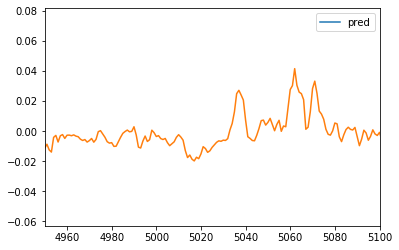

In [8]:
x = torch.tensor(dataset[1][0].unsqueeze(0).to(device))
x_pred,z_test = autoencoder(x)
plt.plot(x_pred[0].detach().cpu().numpy(),label="pred")
plt.plot(x[0].detach().cpu().numpy())
#plt.plot(dataset[1][2])

plt.xlim(4950,5100)
plt.legend()

### Creating full dataset vectors

In [ ]:
considered_parameters = ["Teff","logg","Fe_H","O_FE","C_FE","Na_FE","Mg_FE","Si_FE","S_FE","Al_FE","P_FE","Ni_FE"] 
y = vector.Vector(np.array([allStar[:n_data][combined_cut[:n_data]][param] for param in considered_parameters])[:,:n_data].T)
y_astronn = vector.AstroNNVector(allStar[:n_data][combined_cut[:n_data]],considered_parameters)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2,interaction_only=True)

In [ ]:
z_ae = vector.LatentVector(dataset,autoencoder,n_data)


#### We notice that one of the features is not at all used by the neural network...

In [ ]:
z_ae.raw[:,(0,1,2,4)]

#### So we discard it

In [ ]:
z = vector.Vector(z_ae.raw[combined_cut[:n_data]],order=2,interaction_only=False)

In [ ]:
w = vector.LinearTransformation(z,y)
nonlinear_w = vector.NonLinearTransformation(z,y)
#nonlinear_w.fit(n_epochs=200)

In [ ]:
i=2
plt.title(considered_parameters[i])
nonlinear_std = np.std(nonlinear_w.predict(z).raw[:,i]-y.raw[:,i])
linear_std = np.std(w.predict(z).raw[:,i]-y.raw[:,i])
astronn_std = np.std(y_astronn.raw[:,i]-y.raw[:,i]+2.5)


plt.scatter(y.raw[:,i],w.predict(z).raw[:,i],s=0.2,label="linear:{:.4f}".format(linear_std))
#plt.scatter(y.raw[:,i],nonlinear_w.predict(z).raw[:,i],s=0.2,label="nonlinear:{:.4f}".format(nonlinear_std))
plt.scatter(y.raw[:,i],y_astronn.raw[:,i],s=0.2,label="astronn:{:.4f}".format(astronn_std))
plt.plot([-2,0.5],[-2,0.5],"red")

plt.legend()

In [ ]:
for i in range(len(considered_parameters)):
    plt.title(considered_parameters[i])
    nonlinear_std = np.std(nonlinear_w.predict(z).raw[:,i]-y.raw[:,i])
    linear_std = np.std(w.predict(z).raw[:,i]-y.raw[:,i])
    astronn_std = np.std(y_astronn.raw[:,i]-y.raw[:,i])


    plt.scatter(y.raw[:,i],w.predict(z).raw[:,i],s=0.2,label="linear:{:.4f}".format(linear_std))
    plt.scatter(y.raw[:,i],nonlinear_w.predict(z).raw[:,i],s=0.2,label="nonlinear:{:.4f}".format(nonlinear_std))
    plt.scatter(y.raw[:,i],y_astronn.raw[:,i],s=0.2,label="astronn:{:.4f}".format(astronn_std))

    plt.legend()
    plt.show()

for i in range(len(considered_parameters)):
    plt.title(considered_parameters[i])
    nonlinear_std = np.std(nonlinear_w.predict(z).raw[:,i]-y.raw[:,i])
    linear_std = np.std(w.predict(z).raw[:,i]-y.raw[:,i])

    plt.scatter(y.raw[:,i],w.predict(z).raw[:,i],s=0.2,label="linear:{:.4f}".format(linear_std))
    plt.scatter(y.raw[:,i],nonlinear_w.predict(z).raw[:,i],s=0.2,label="nonlinear:{:.4f}".format(nonlinear_std))
    plt.legend()
    plt.show()

In [ ]:
for i in range(len(considered_parameters)):
    plt.title(considered_parameters[i])
    nonlinear_std = np.std(nonlinear_w.predict(z).raw[:,i]-y.raw[:,i])
    linear_std = np.std(w.predict(z).raw[:,i]-y.raw[:,i])

    plt.scatter(y.raw[:,i],w.predict(z).raw[:,i],s=0.2,label="linear:{:.4f}".format(linear_std))
    plt.scatter(y.raw[:,i],nonlinear_w.predict(z).raw[:,i],s=0.2,label="nonlinear:{:.4f}".format(nonlinear_std))
    plt.legend()
    plt.show()

In [ ]:
for i in range(10):
    plt.title(considered_parameters[i])
    plt.hist(nonlinear_w.predict(z).raw[:,i]-y.raw[:,i],alpha=0.5,label="diff")
    plt.hist(w.predict(z).raw[:,i]-y.raw[:,i],alpha=0.5,label="linear_diff")
    plt.hist(y.raw[:,i]-np.mean(y.raw[:,i]),alpha=0.5,label="param")
    plt.legend()
    plt.show()


## Looking at Open Clusters

In [6]:
occam = load("occam")
allStar_occam = occam["allStar"]

In [7]:
dataset_occam = AspcapDataset(allStar_occam,recenter=True,tensor_type=torch.FloatTensor,filling_dataset=dataset.dataset["aspcap"])

0
1
2
3
4
5
6
7
8


KeyboardInterrupt: 

In [ ]:
occam_cluster_idxs = occam["cluster_idxs"]
z_occam = vector.OccamLatentVector(occam_cluster_idxs,dataset=dataset_occam,autoencoder = autoencoder,n_data = len(dataset_occam))


occam = load("occam")
allStar_occam = occam["allStar"]
dataset_occam = ApogeeDataset(allStar_occam,outputs = ["aspcap","mask","physical","idx"])
occam_cluster_idxs = occam["cluster_idxs"]
z_occam = vector.OccamLatentVector(dataset_occam,autoencoder,occam_cluster_idxs,len(dataset_occam))


In [ ]:
bad_indexes = []
for i in range(len(z_occam.raw)):
    err = np.sqrt(np.sum(((z_occam.get_x(i)[mask_elem.astype(bool)]-z_occam.get_x_pred(i))**2).detach().numpy()))
    print(err)
    if err>0.5:
        print(err)
        print(i)
        bad_indexes.append(i)
        plt.plot(z_occam.get_x(i)[mask_elem.astype(bool)])
        plt.plot(z_occam.get_x_pred(i))
        #z_occam.plot(i)
        plt.show()

In [ ]:
retained= np.delete(np.arange(len(z_occam.raw)),bad_indexes)
retained

In [ ]:
z_occam = vector.OccamLatentVector(occam_cluster_idxs,raw=z_occam.raw,order=2,interaction_only=False)

In [ ]:
z_occam.raw.shape

dataset_occam = ApogeeDataset(allStar_occam[retained],outputs = ["aspcap","mask","physical","idx"])
occam_cluster_idxs = occam["cluster_idxs"][retained]
z_occam = vector.OccamLatentVector(dataset_occam,autoencoder,occam_cluster_idxs,len(dataset_occam))


In [10]:
clust_idxs =z_occam.registry["NGC 6819"]

NameError: name 'z_occam' is not defined

In [11]:
i=2
elem = considered_parameters[i]
plt.hist(z_occam.dataset.allStar[clust_idxs][elem],bins=9)
plt.hist(z_occam.dataset.allStar[elem],bins=50,alpha=0.2)
plt.title(elem)
#plt.xlim(-0.25,0.25)

NameError: name 'considered_parameters' is not defined

In [ ]:
plt.hist(w.predict(z_occam).raw[:,i][clust_idxs],bins=9)
plt.hist(w.predict(z_occam).raw[:,i],bins=50,alpha=0.2)
#plt.hist(vector.project(z_occam.centered,w.val)[i],bins=50,alpha=0.2)

#plt.xlim(-0.25,0.25)
plt.title(considered_parameters[i])

In [ ]:
plt.hist(nonlinear_w.predict(z_occam).raw[:,i][clust_idxs],bins=9)
plt.hist(nonlinear_w.predict(z_occam).raw[:,i],bins=50,alpha=0.2)
#plt.hist(vector.project(z_occam.centered,w.val)[i],bins=50,alpha=0.2)

#plt.xlim(-0.25,0.25)
plt.title(considered_parameters[i])

### PCA investigation

In [ ]:
whitener = PCA(n_components=z.raw.shape[1],whiten=True)#z.raw.shape[1],whiten=True)


In [ ]:
whitener.fit(z.centered)

In [ ]:
z_ae.raw[5]

In [ ]:
z.raw[1]

In [ ]:
w_z_c = whitener.transform(z.centered)
w_z_occam_c = whitener.transform(z_occam.cluster_centered)

In [ ]:
pca = PCA(n_components=z.raw.shape[1])#z.raw.shape[1])


In [ ]:
pca.fit(w_z_c[:250,:])


In [ ]:
pca.fit(w_z_occam_c)

In [ ]:
w_z_occam_c.shape

In [ ]:
pca.explained_variance_

In [ ]:
pca.explained_variance_

In [ ]:
for i in range(8):
    plt.hist(z.raw[:,i],bins=100,alpha=0.2,density=True)
    plt.hist(z_occam.raw[:,i],alpha=0.5,bins=20,density=True)
    plt.show()

We can look at the variance along one direction across all clusters

In [ ]:
dim = 19
zc_b = vector.project(w_z_c,pca.components_[dim][None,:])
zoccam_b = vector.project(w_z_occam_c,pca.components_[dim][None,:])
sorted_zc_idx = np.abs(zc_b).argsort()
sorted_zoccam_idx = np.abs(zoccam_b).argsort()


var_occam  = np.var(zoccam_b[sorted_zoccam_idx[:150]])
var_raw = np.var(zc_b[sorted_zc_idx[:6000]])
print(f"occam:{var_occam}")
print(f"raw:{var_raw}")
print(var_raw/var_occam)


plt.hist(zoccam_b,alpha=0.2,label="diff",bins=50,density=True)
plt.hist(zc_b[sorted_zc_idx[:7000]],alpha=0.2,label="full",bins=50, density=True)
plt.legend()
#plt.xlim(-3,3)

We can compare this to the raw abundances

In [ ]:
flatten = lambda l: [item for sublist in l for item in sublist]

In [ ]:
considered_parameters

In [ ]:
abundances_occam = []
elem = "Fe_H"
elem_idx = considered_parameters.index(elem)

for cluster in z_occam.registry:
    clust_idxs = z_occam.registry[cluster]
    abundances_occam.append(dataset_occam.allStar[clust_idxs][elem]-np.mean(dataset_occam.allStar[clust_idxs][elem]))
    #print(z_occam.dataset.allStar[clust_idxs][elem]-z_occam.dataset.allStar[clust_idxs][elem])
abundances_occam = flatten(abundances_occam)

In [ ]:
var_occam = np.var(abundances_occam)
var_raw = np.var(y.raw[:,elem_idx]-np.mean(y.raw[:,elem_idx]))
print(f"occam:{var_occam}")
print(f"raw:{var_raw}")
print(var_raw/var_occam) 

plt.hist(abundances_occam,alpha=0.2,label="diff",bins=50,density=True)
plt.hist(y.raw[:,elem_idx]-np.mean(y.raw[:,elem_idx]),alpha=0.2,label="full",bins=50, density=True)

### We can also compare to the astronn abundances

In [ ]:
y_astronn = vector.AstroNNVector(allStar[:n_data][combined_cut[:n_data]],considered_parameters)
y_astronn_occam = vector.AstroNNVector(allStar_occam,considered_parameters)

In [ ]:
i=2
plt.scatter(y_astronn.raw[:,i],y.raw[:,i],s=1,alpha=0.5)
#plt.scatter(nonlinear_w.predict(z).raw[:,i],y.raw[:,i],s=0.1,alpha=0.5)
plt.xlim(-0.1,0.1)
plt.ylim(-0.1,0.1)

In [ ]:
considered_parameters

In [ ]:
abundances_occam = []
elem = "Fe_H"
elem_idx = considered_parameters.index(elem)

for cluster in z_occam.registry:
    clust_idxs = z_occam.registry[cluster]
    abundances_occam.append(y_astronn_occam.raw[clust_idxs,elem_idx]-np.mean(y_astronn_occam.raw[clust_idxs,elem_idx]))
    #print(z_occam.dataset.allStar[clust_idxs][elem]-z_occam.dataset.allStar[clust_idxs][elem])
abundances_occam = np.array(flatten(abundances_occam))

In [ ]:
abundances_all  =y_astronn.raw[:,elem_idx]-np.mean(y_astronn.raw[:,elem_idx])
sorted_zc_idx = np.abs(abundances_all).argsort()
sorted_occam_idx = np.abs(abundances_occam).argsort()

var_occam = np.var(np.array(abundances_occam)[sorted_occam_idx[:150]])
var_raw = np.var(abundances_all[sorted_zc_idx[:6000]])


print(f"occam:{np.var(abundances_occam)}")
print(f"raw:{var_raw}")
print(var_raw/var_occam) 


plt.hist(np.array(abundances_occam),alpha=0.2,label="diff",bins=50,density=True)
plt.hist(abundances_all[sorted_zc_idx[:7200]],alpha=0.2,label="full",bins=50, density=True)

In [ ]:
def summarize_representation(z_all, z_occam, percentage_all=0.1, percentage_occam=0.1,plot_cut=True):
    """Function to plot the histogram summary of a method
    z_all: np.array
        representation of full dataset
    z_occam: np.array
        representation of chemical clusters
    percentage_all: float
        Fraction of outliers in full dataset to cut. Used for result to not depend on outliers.
    percentage_occam: float
            Fraction of outliers in occam dataset to cut. Used for result to not depend on outliers.
    plot_cut: boolean
        whether to plot the raw or cut distribution
    """
    n_all = round(len(z_all)*percentage_all)
    n_occam = round(len(z_occam)*percentage_occam)
    sorted_all = z_all[np.abs(z_all).argsort()]
    sorted_occam = z_occam[np.abs(z_occam).argsort()]
    if n_occam!=0:
        var_occam = np.var(sorted_occam[:-n_occam])
    else:
        var_occam = np.var(sorted_occam)
    if n_all!=0:
        var_raw = np.var(sorted_all[:-n_all])
    else:
        var_raw = np.var(sorted_all)
    print(f"occam: {var_occam}")
    print(f"raw: {var_raw}")
    print(f"ratio: {var_raw/var_occam}")
    if plot_cut is True and n_all!=0 and n_occam!=0: 
        plt.hist(sorted_occam[:-n_occam],alpha=0.2,label="diff",bins=20,density=True)
        plt.hist(sorted_all[:-n_all],alpha=0.2,label="full",bins=20, density=True)
    else:
        print("here")
        plt.hist(sorted_occam,alpha=0.2,label="diff",bins=20,density=True)
        plt.hist(sorted_all,alpha=0.2,label="full",bins=20, density=True)


In [ ]:
summarize_representation(zc_b,zoccam_b,0.1,0.1)

In [ ]:
summarize_representation(abundances_all,abundances_occam)

In [ ]:
z_all = abundances_all
z_occam = abundances_occam
percentage_all = 0.1
percentage_occam = 0.1
n_all = round(len(z_all)*percentage_all)
n_occam = round(len(z_occam)*percentage_occam)
sorted_all = z_all[np.abs(z_all).argsort()]
sorted_occam = z_occam[np.abs(z_occam).argsort()]
var_occam = np.var(sorted_occam[:-n_occam])

In [ ]:
round(n_all)

In [ ]:
len(sorted_occam[:-1])

In [ ]:
abundances_all.shape

In [ ]:
np.array(abundances_occam)[sorted_occam_idx][-10:]

In [ ]:
dim = 4
zc_b = vector.project(w_z_c,pca.components_[dim][None,:])
zoccam_b = vector.project(w_z_occam_c,pca.components_[dim][None,:])
print(f"occam:{np.var(vector.project(w_z_occam_c,pca.components_[dim][None,:]))}")
print(f"raw:{np.var(vector.project(w_z_c,pca.components_[dim][None,:]))}")

plt.hist(zoccam_b,alpha=0.2,label="diff",bins=50,density=True)
plt.hist(zc_b,alpha=0.2,label="full",bins=50, density=True)
plt.legend()

How do these directions coincide with the raw abundances?

In [ ]:
w = vector.LinearTransformation(vector.Vector(w_z_c),y)


In [ ]:
import sklearn
sklearn.metrics.pairwise.cosine_similarity(pca.components_[9][None,:].reshape(1, -1),w.val[2].reshape(1, -1))

In [ ]:
allStar = allStar_behaved_restricted
idx=6
apogee_id,loc,telescope = allStar[idx]["APOGEE_ID"],allStar[idx]["FIELD"], allStar[idx]["TELESCOPE"]
spec = apread.aspcapStar(loc_id=str(loc),apogee_id=apogee_id,telescope=telescope,ext=0)
spec1 = apread.aspcapStar(loc_id=str(loc),apogee_id=apogee_id,telescope=telescope,ext=1)
spec2 = apread.aspcapStar(loc_id=str(loc),apogee_id=apogee_id,telescope=telescope,ext=3)


In [ ]:
plt.plot(spec[0])
plt.plot(spec1[0])
plt.plot(spec2[0])
#plt.plot(spec2[0])
plt.xlim(4000,4300)

In [ ]:
allStar_behaved_restricted =  load("allStar_training_restricted")

In [ ]:
idx=6
apogee_id,loc,telescope = allStar[idx]["APOGEE_ID"],allStar[idx]["FIELD"], allStar[idx]["TELESCOPE"]
spec = apread.aspcapStar(loc_id=str(loc),apogee_id=apogee_id,telescope=telescope,ext=0)
spec1 = apread.aspcapStar(loc_id=str(loc),apogee_id=apogee_id,telescope=telescope,ext=1)
spec2 = apread.aspcapStar(loc_id=str(loc),apogee_id=apogee_id,telescope=telescope,ext=3)

plt.plot(spec1[0])
plt.plot(dataset.dataset["aspcap"][idx])
plt.xlim(1700,1800)

In [ ]:
idx=5
apogee_id,loc,telescope = allStar[idx]["APOGEE_ID"],allStar[idx]["FIELD"], allStar[idx]["TELESCOPE"]
spec = apread.aspcapStar(loc_id=str(loc),apogee_id=apogee_id,telescope=telescope,ext=1)
spec_err = apread.aspcapStar(loc_id=str(loc),apogee_id=apogee_id,telescope=telescope,ext=2)
spec_fit = apread.aspcapStar(loc_id=str(loc),apogee_id=apogee_id,telescope=telescope,ext=3)
plt.plot(spec[0],label="raw")
plt.plot(z.get_x_pred(idx),label="nn")
#plt.plot(z.get_x(idx),label="nn")
plt.plot(spec_fit[0],label="fit")
plt.xlim(4200,4300)
plt.legend()

In [ ]:
#plt.plot(spec_fit[0]-z.get_x_pred(idx),label="fit")
#plt.plot(spec_fit[0]-z.get_x(idx).numpy(),label="fit",alpha=0.3)
plt.plot(z.get_x_pred(idx)-z.get_x(idx).numpy(),label="nn",alpha=0.3)
plt.plot(spec_err[0],label="err",alpha=0.3)
plt.xlim(500,900)
plt.ylim(0,0.02)
plt.legend()

In [ ]:
np.var(spec_fit[0]-z.get_x(idx).numpy())

In [ ]:
np.var(z.get_x_pred(idx)-z.get_x(idx).numpy())

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2,interaction_only=True)

In [ ]:
poly.fit_transform(z.raw[:,:]).shape